# Cell Transmission Model

_This project is **transportation engineering** coursework_  
_The source code, data, picture has been open sourced:  [Lumozz's Github CTM](https://github.com/Lumozz/CTM)  MIT license_

### content
- Set Parameters of Basic Traffic Characteristic
- Implementation of The Simulation Algorithm
- Simulation and Plotting
- Qusetion and Answer

# Set Parameters of Basic Traffic Characteristic

### Traffic Flow Parameters  
- Assume that the parameters of each lane：


<center>$ Q_{max}=1800veh/h $  </center>
<center>$ K_{max}=30veh/km$  </center>
<center>$ K_{jam}=125veh/km$  </center>
<center>$ V_{free}=60km/h$  </center>
  
 
- The relationship between **traffic flow rate**$Q$and**traffic density**$K$is simplified as a triangle.
- Set the simulation time interval (time step) $t$ to 3 seconds.  
<img src="pic/qk.png" width = "400" height = "300" alt="pic" align=center />

### Road Structure Parameters
- Assume that the length of the road is $3km$,two lanes in one direction.  
- According to the CTM theory, in the initial free-flow state, the vehicles in a $cell$ should move to the next cell exactly after each time step，so that the cell length is $l=V_{free}\times t=60km/h \times 3s =50m$  the road of length 1km is divided into 20 parts of 50m each.
- Many assumptions are made here, mainly to verify the accuracy of the code, and after it is written, these parameters can be freely changed in the framework of the basic theory of traffic flow to obtain richer simulation results.

# Implementation of The Simulation Algorithm

### Import Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

### Implementation of the CTM class：  
- Initialize hyperparameters
- Implementing supply and demand calculation functions
- Realize simulation iterative operations with fixed parameters
- Construct the barrier function to realize the stop&go effect


In [2]:
class ctm():
    def __init__(self):
        self.total_step = 250
        self.Q_max_per_lane = 2250 / 3600  # veh/s
        self.K_jam_per_lane = 125 / 1000  # veh/m
        self.V_free_per_lane = 60 / 3.6  # m/s
        self.K_max_per_lane = self.Q_max_per_lane / self.V_free_per_lane

        self.init_rate = 0.8

        self.time_step = 3  # s
        self.g_num_lane = 2
        self.l_road = 3000  # m
        self.l_cell = self.V_free_per_lane * self.time_step
        self.num_cell = self.l_road / self.l_cell + 2

        if self.num_cell % 1 != 0:
            print('Wrong, the road can not be divided by the whole')
        else:
            self.num_cell = int(self.num_cell)

        self.capacity = np.ones(self.num_cell) * self.K_jam_per_lane * self.l_cell
        self.capacity[0] = 999
        self.capacity[-1] = 999

        self.occupancy = np.zeros(self.num_cell)
        self.occupancy[0] = self.init_rate * self.K_max_per_lane * self.l_cell

        self.num_lane = np.ones(self.num_cell) * self.g_num_lane

        self.block_position = self.num_cell - 1
        self.release_time = 1

    def get_Q_in(self, occupancy):
        k = occupancy / self.l_cell

        if k <= self.Q_max_per_lane / self.V_free_per_lane:
            q = self.Q_max_per_lane
        else:
            q = -((self.Q_max_per_lane) / (self.K_jam_per_lane - self.K_max_per_lane)) * (k - self.K_jam_per_lane)
        return q

    def get_Q_out(self, occupancy):
        k = occupancy / self.l_cell
        if k <= self.Q_max_per_lane / self.V_free_per_lane:
            q = (self.Q_max_per_lane / self.K_max_per_lane) * k
        else:
            q = self.Q_max_per_lane
        return q

    def get_Q(self, occupancy):

        k = occupancy / self.l_cell
        q = k.copy()

        q[q >= self.Q_max_per_lane / self.V_free_per_lane] = 999

        q[q < self.Q_max_per_lane / self.V_free_per_lane] = (self.Q_max_per_lane / self.K_max_per_lane) * \
                                                            k[k < self.Q_max_per_lane / self.V_free_per_lane]

        q[q >= 998] = \
            -((self.Q_max_per_lane) / (self.K_jam_per_lane - self.K_max_per_lane)) * \
            (k[k >= self.Q_max_per_lane / self.V_free_per_lane] - self.K_jam_per_lane)

        return q

    def get_V(self, occupancy):
        k = occupancy / self.l_cell
        q = self.get_Q(occupancy)
        k[k>0] = q[k>0] / k[k>0]

        return k

    def set_block(self, position, release_time):
        self.block_position = position
        self.release_time = release_time
        self.capacity[self.block_position] = 0

    def sim(self):
        self.occupancy_next = np.zeros_like(self.occupancy)
        log = np.zeros_like(self.occupancy)

        for step in range(0, self.total_step):
            if step == self.release_time:
                self.capacity[self.block_position] = self.K_jam_per_lane * self.l_cell
            for i in range(0, self.num_cell):
                if i == 0 or i == self.num_cell - 1:
                    self.occupancy_next[i] = self.occupancy[i]
                    continue

                num_in = min(self.get_Q_out(self.occupancy[i - 1]) * self.num_lane[i - 1] * self.time_step, \
                             self.get_Q_in(self.occupancy[i]) * self.num_lane[i] * self.time_step)
                cell_in = min(self.occupancy[i - 1] * self.num_lane[i - 1], num_in, \
                              self.capacity[i] * self.num_lane[i] - self.occupancy[i] * self.num_lane[i])

                num_out = min(self.get_Q_out(self.occupancy[i]) * self.num_lane[i] * self.time_step, \
                              self.get_Q_in(self.occupancy[i + 1]) * self.num_lane[i + 1] * self.time_step)
                cell_out = min(self.occupancy[i] * self.num_lane[i], num_out, \
                               self.capacity[i + 1] * self.num_lane[i + 1] - self.occupancy[i + 1] * self.num_lane[
                                   i + 1])

                self.occupancy_next[i] = (self.occupancy[i] * self.num_lane[i] + cell_in - cell_out) / self.num_lane[i]
            self.occupancy = self.occupancy_next.copy()
            log = np.vstack([log, self.occupancy])
            tlog = log * self.num_lane

        result_occupancy_lane = log
        result_occupancy_total = tlog

        result_K_lane = log / self.l_cell
        result_K_total = tlog / self.l_cell

        result_Q_lane = self.get_Q(log)
        result_Q_total = result_Q_lane * self.num_lane

        result_V_lane = self.get_V(log)
        result_V_total = result_V_lane
        return result_occupancy_lane, result_occupancy_total, \
               result_K_lane, result_K_total, \
               result_Q_lane, result_Q_total, \
               result_V_lane, result_V_total

   
- In the `sim()` function, for each $cell$ , at time t , calculate the number of input vehicles and the number of output vehicles, i.e. calculate the demand for the previous $cell$ and the supply for the next $cell$：


<center>$cell_{in}^{i} = min(cell_{occupancy}^{i-1},min(Q^{i-1},Q^{i}),cell_{capacity}^{i}-cell_{occupancy}^{i})$ </center>   

<center>$cell_{out}^{i} = min(cell_{occupancy}^{i},min(Q^{i},Q^{i+1}),cell_{capacity}^{i+1}-cell_{occupancy}^{i+1})$ </center>  
  
- Where the left side of the equation is the current moment quantity and the right side of the equation is the time $t-1$ quantity. It follows that the input and output quantities of all $cell$ at the current moment are only related to the system state at the previous moment and are not related to the quantities of other $cell$ at the current moment, so they do not need to be calculated in a specific order.  

- The second term $min(Q^{i-1},Q^{i})$ and $min(Q^{i},Q^{i+1})$ are the input and output quantities of $cell^{i}$ limited by the traffic volume, calculated by the `get_Q_in` and `get_Q_out` functions.
- It is important to note that the input and output quantities here are not equivalent to the demand and supply quantities and should be distinguished.  


- Finally：  


<center>$cell_{t}^{i}=cell_{t-1}^{i}+cell_{in}^{i}-cell_{out}^{i}$</center>  
  
- The`set_block()`function exists to implement the effect of “stop and go”。
    - In this function, an easy way is used to set the capacity of a section of $cell$ to zero (`self.capacity[i]=0`), so that since then, the traffic flow from the previous node cannot flow into this node, and the demand, inflow at this node is always zero according to the above equation. Vehicles traveling to this node must wait in place.  
    - Further, in order to automate the simulation, a **release time** is set, i.e., when running to a certain time step, the original capacity of this cell is restored so that the vehicle can continue to the end point as if it were passing through other $cell$.

# Simulation and Plotting  
- Intuitive images are a good tool to observe the traffic status. Here, the number heat map of vehicle Num, density K, flow rate Q, and speed V is plotted for each $cell$ with time step as the horizontal coordinate and road length as the vertical coordinate, and each item is further divided into single lane and total of all lanes.

In [3]:
def pic(start,end,position=40,release_time=70):
    model = ctm()
    if start!=end:
        model.num_lane[start:end] = 3
        
    model.set_block(position,release_time)
    
    result_occupancy_lane,result_occupancy_total,\
                result_K_lane,result_K_total,\
                result_Q_lane,result_Q_total,\
                result_V_lane,result_V_total\
    = model.sim()
    

    return result_occupancy_lane,result_occupancy_total,\
                result_K_lane,result_K_total,\
                result_Q_lane,result_Q_total,\
                result_V_lane,result_V_total

### shock absorber

- In order to test the impact of shock absorber on traffic flow, 15 different lengths of shock absorber were tested here, all of which were extended from 0 to 15 $cells$ in the upstream direction starting from the place where the blockage was generated.

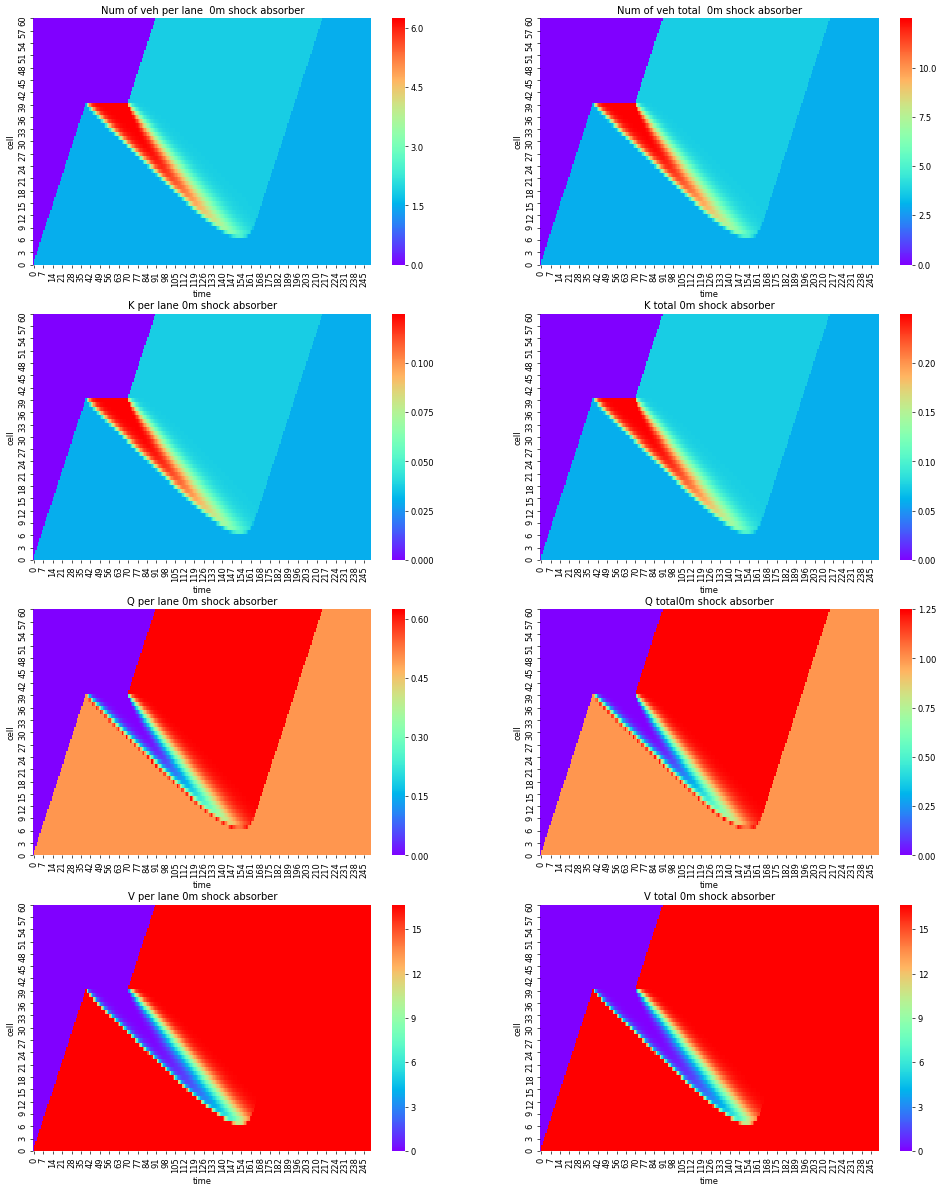

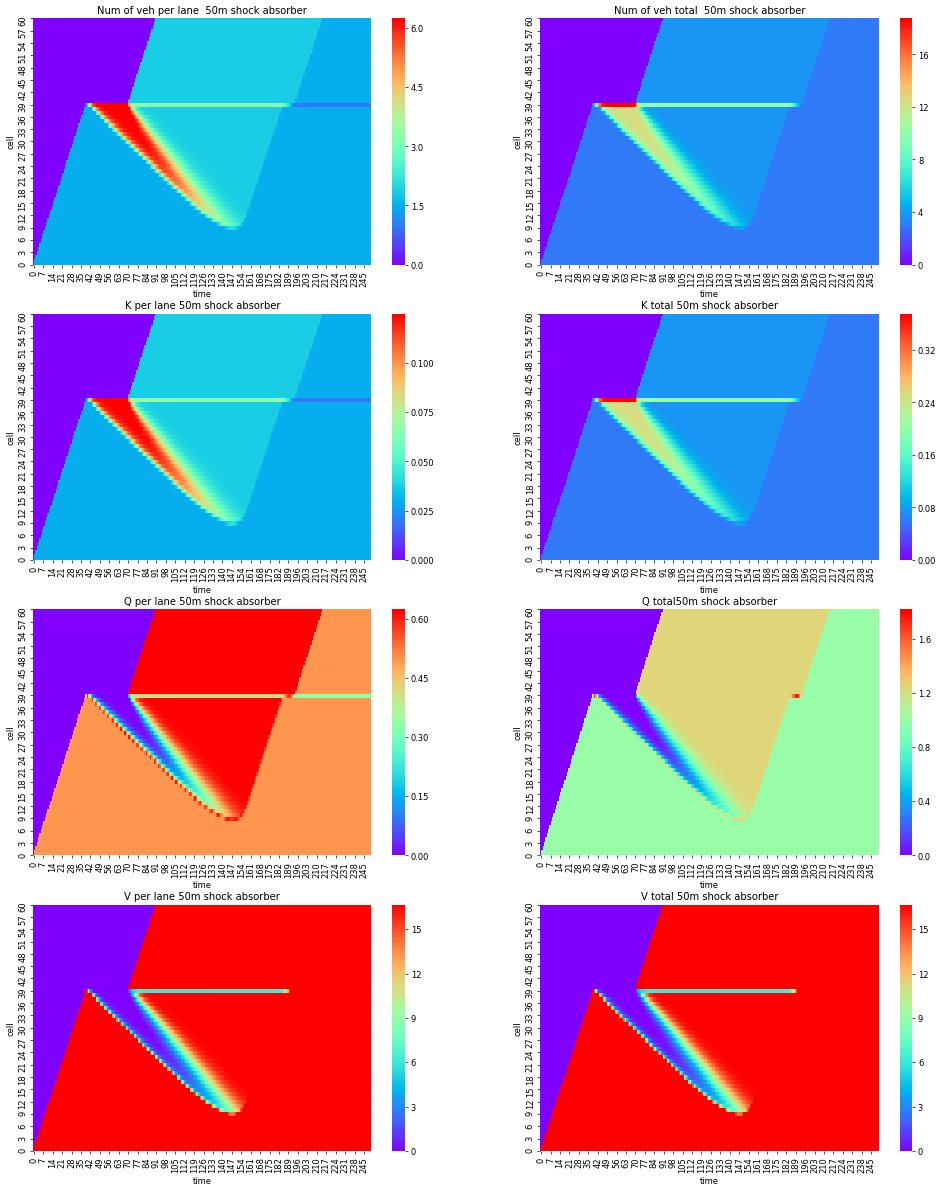

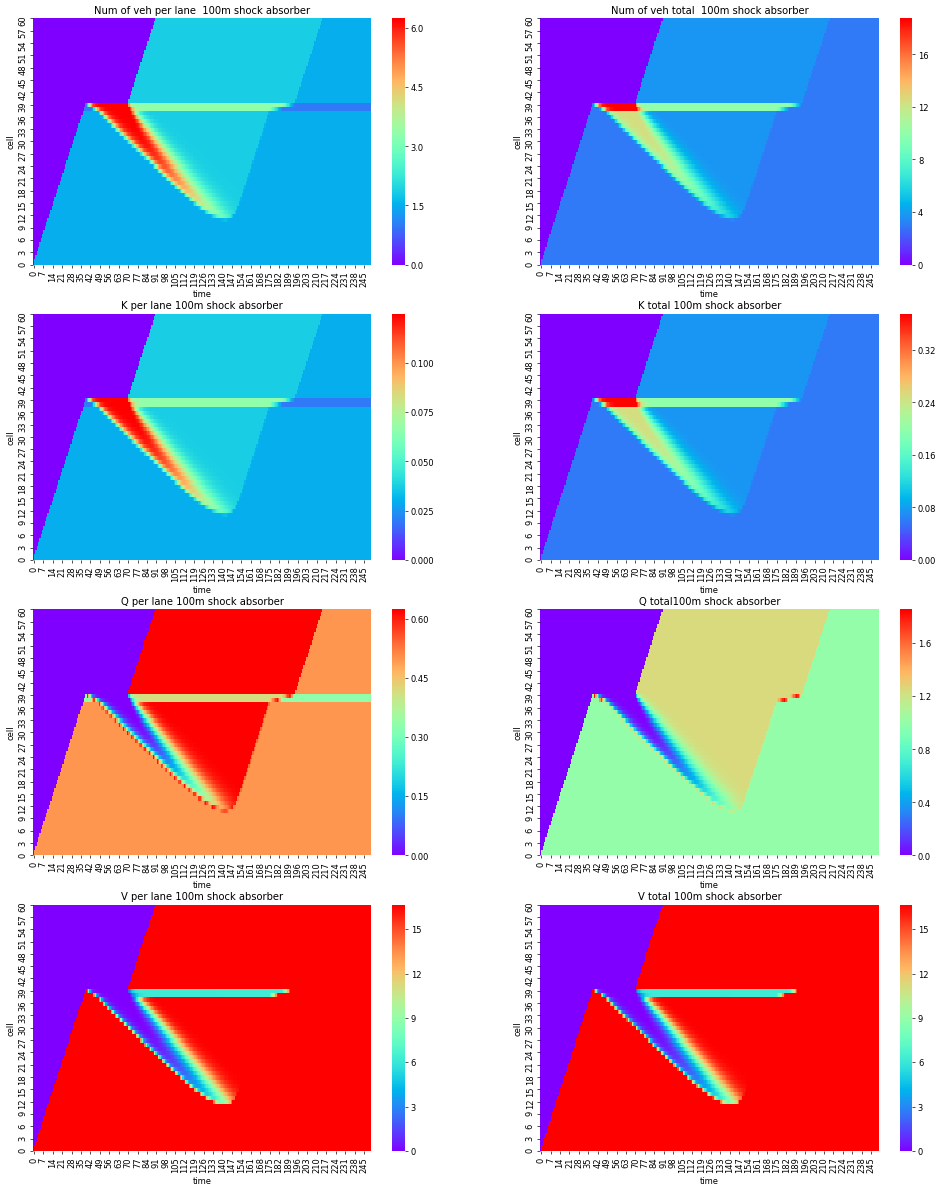

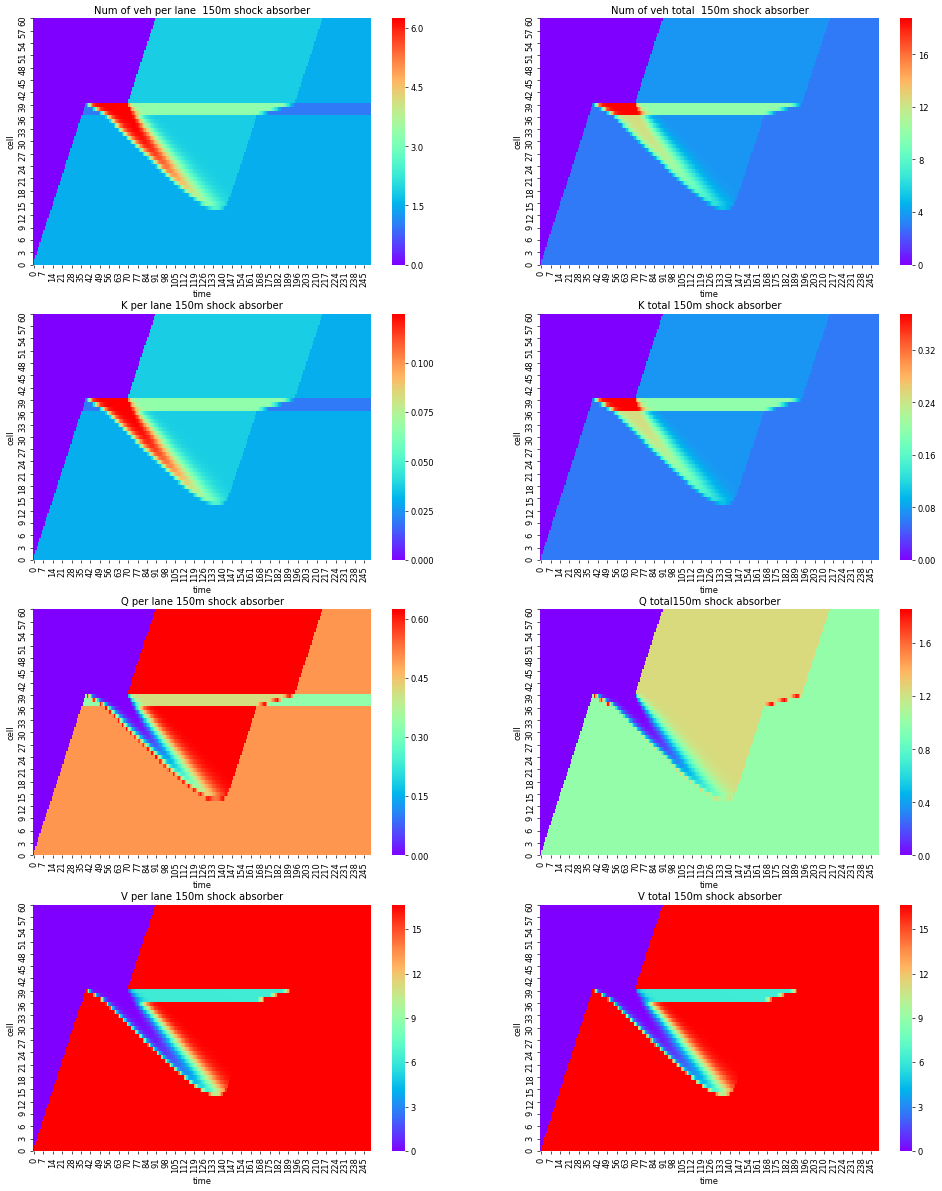

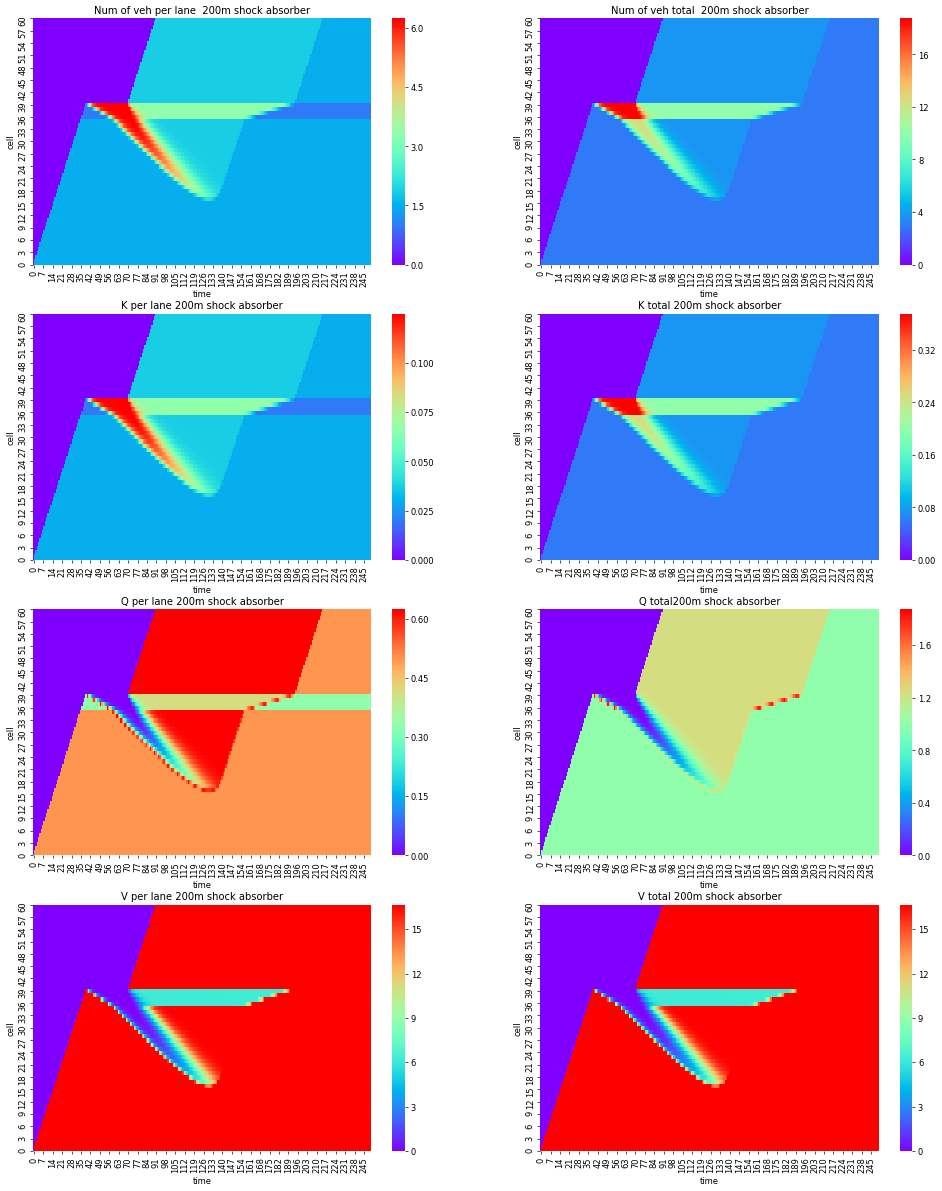

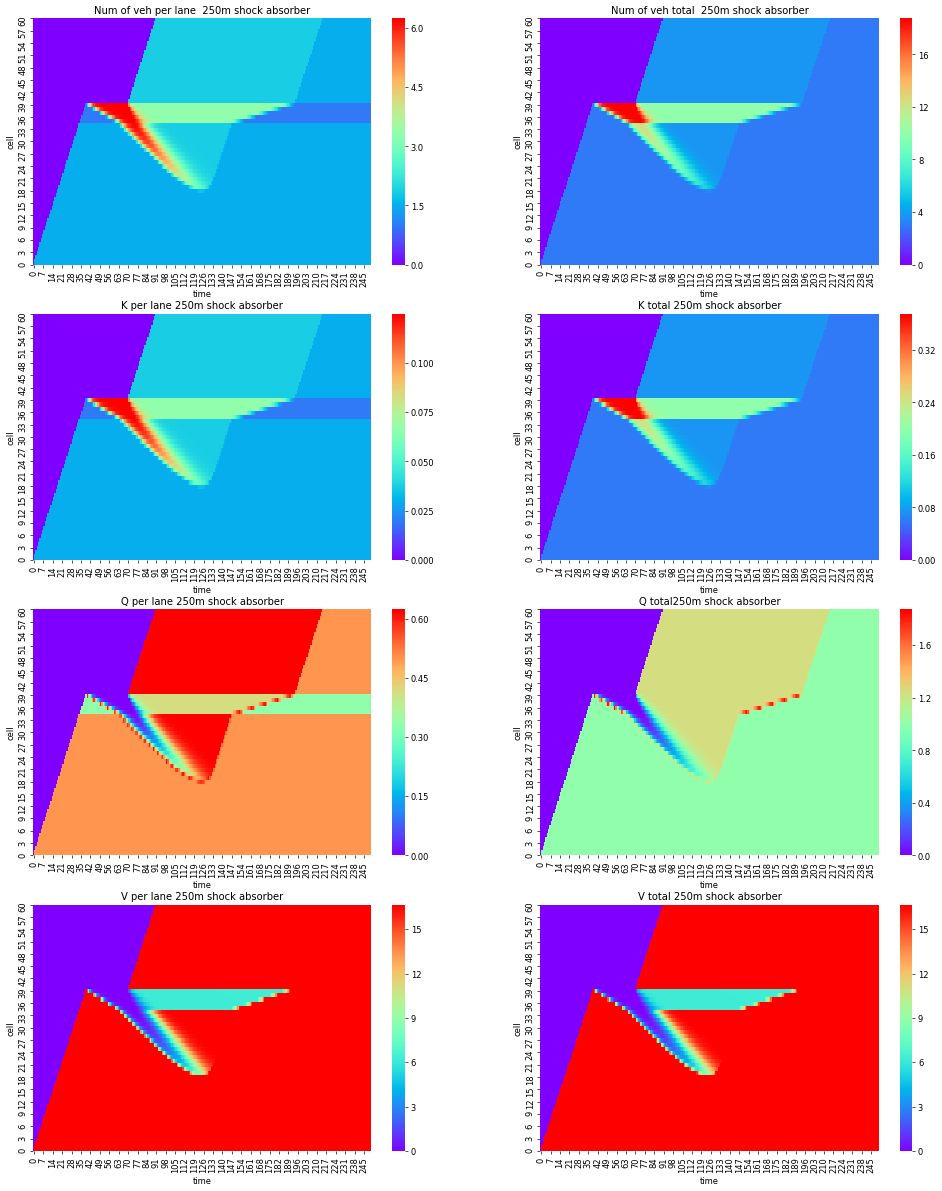

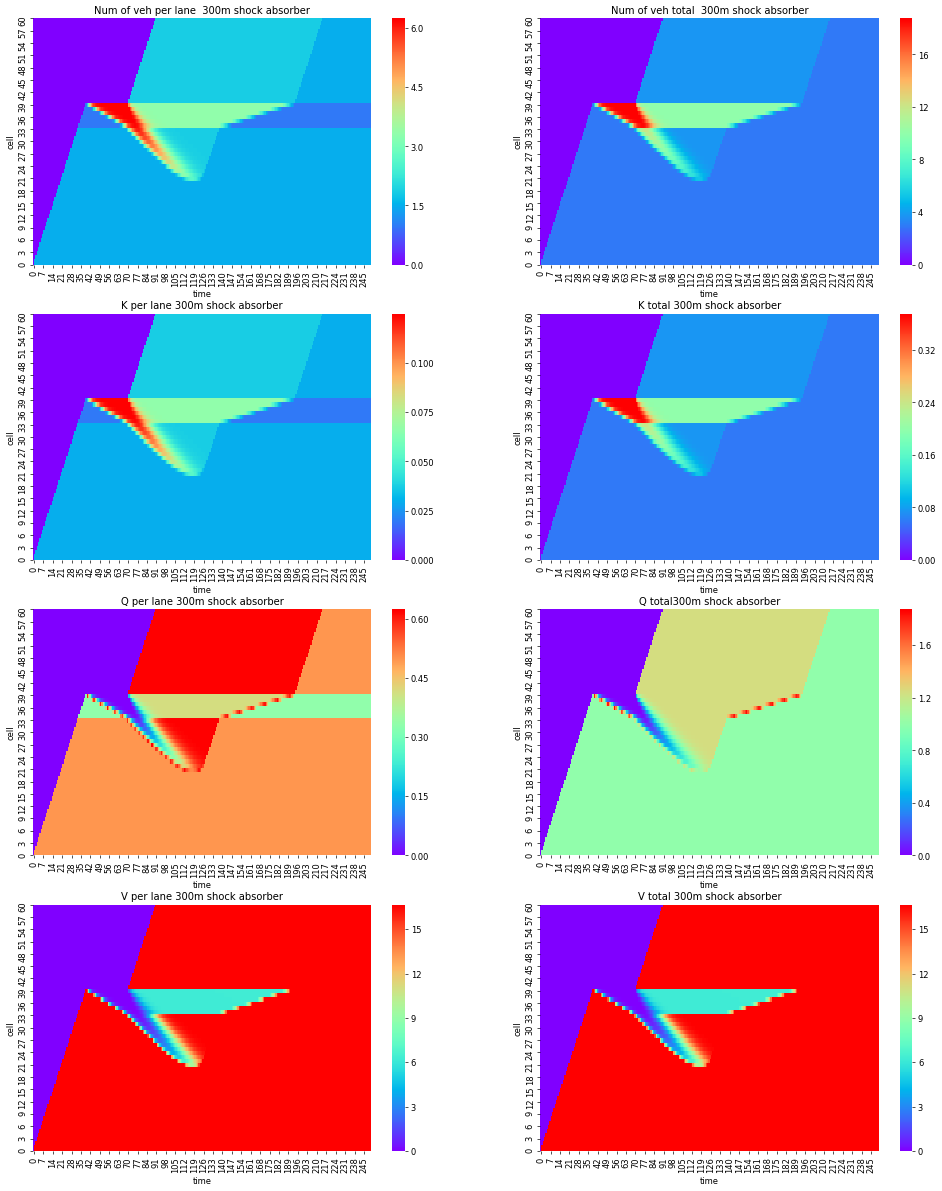

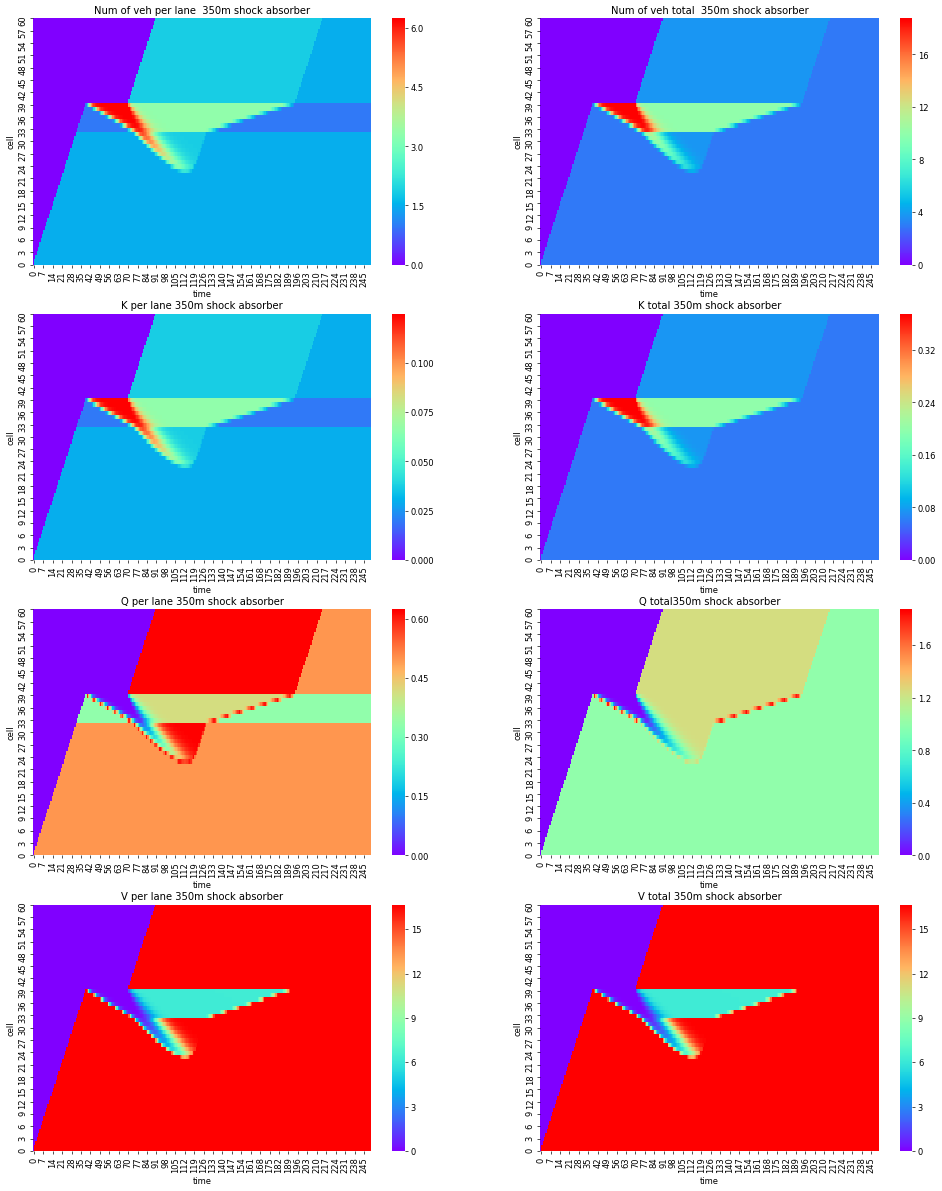

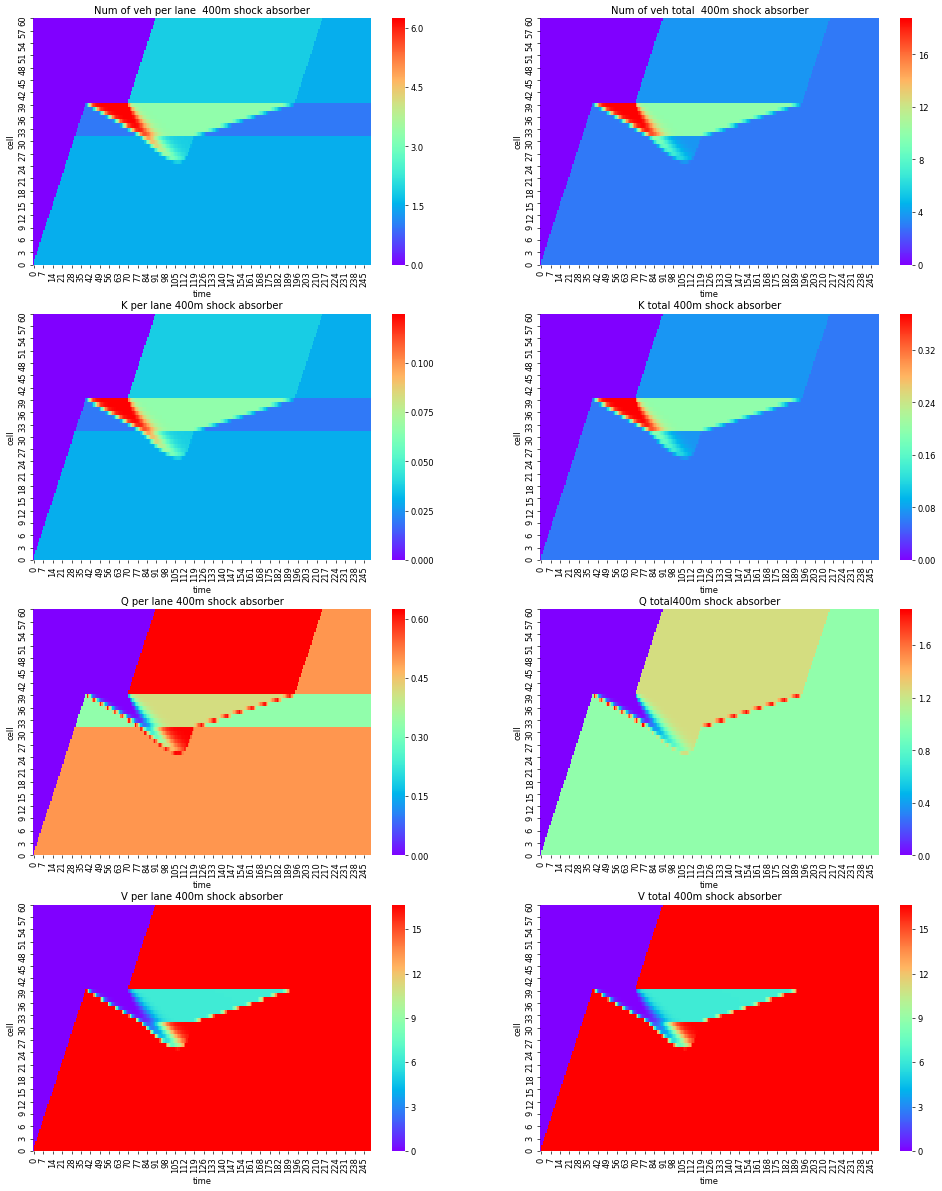

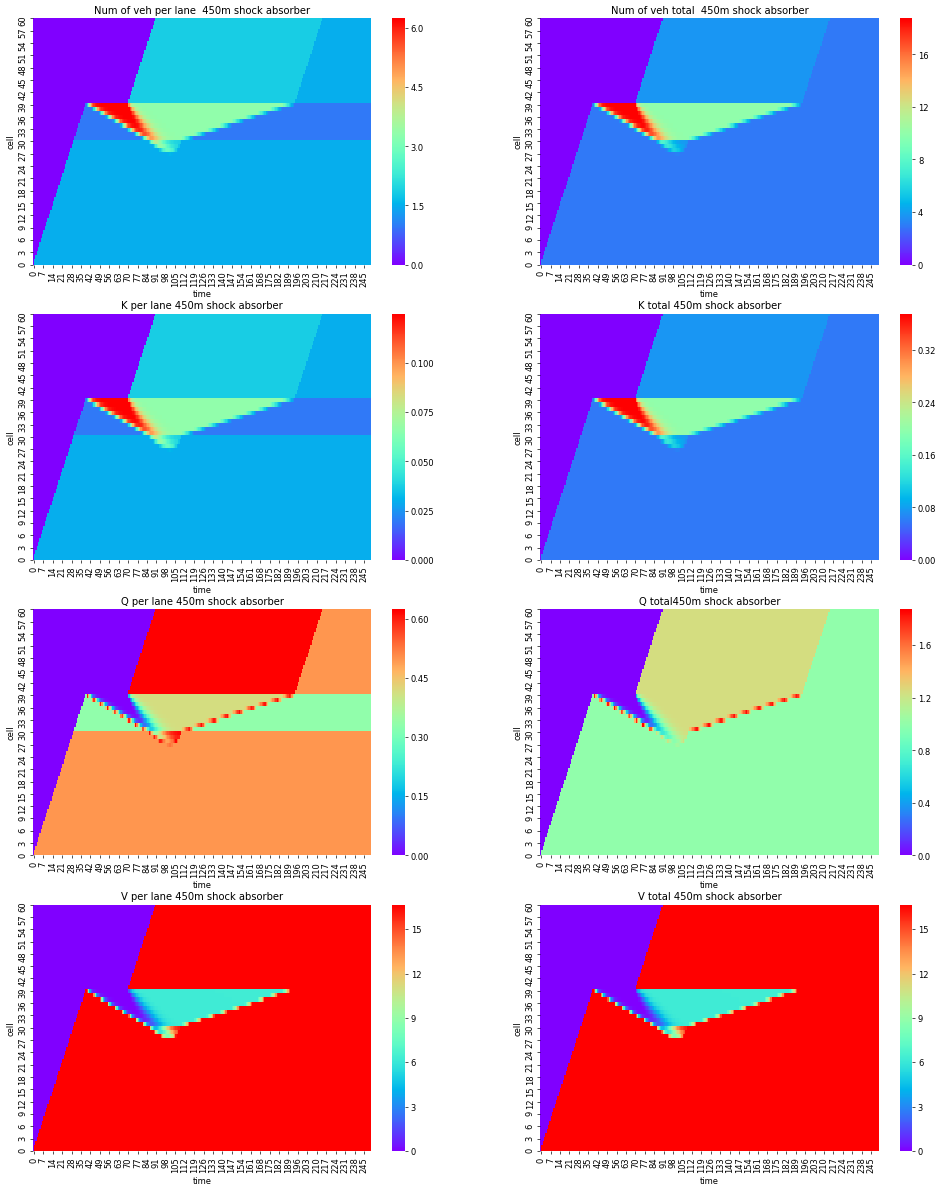

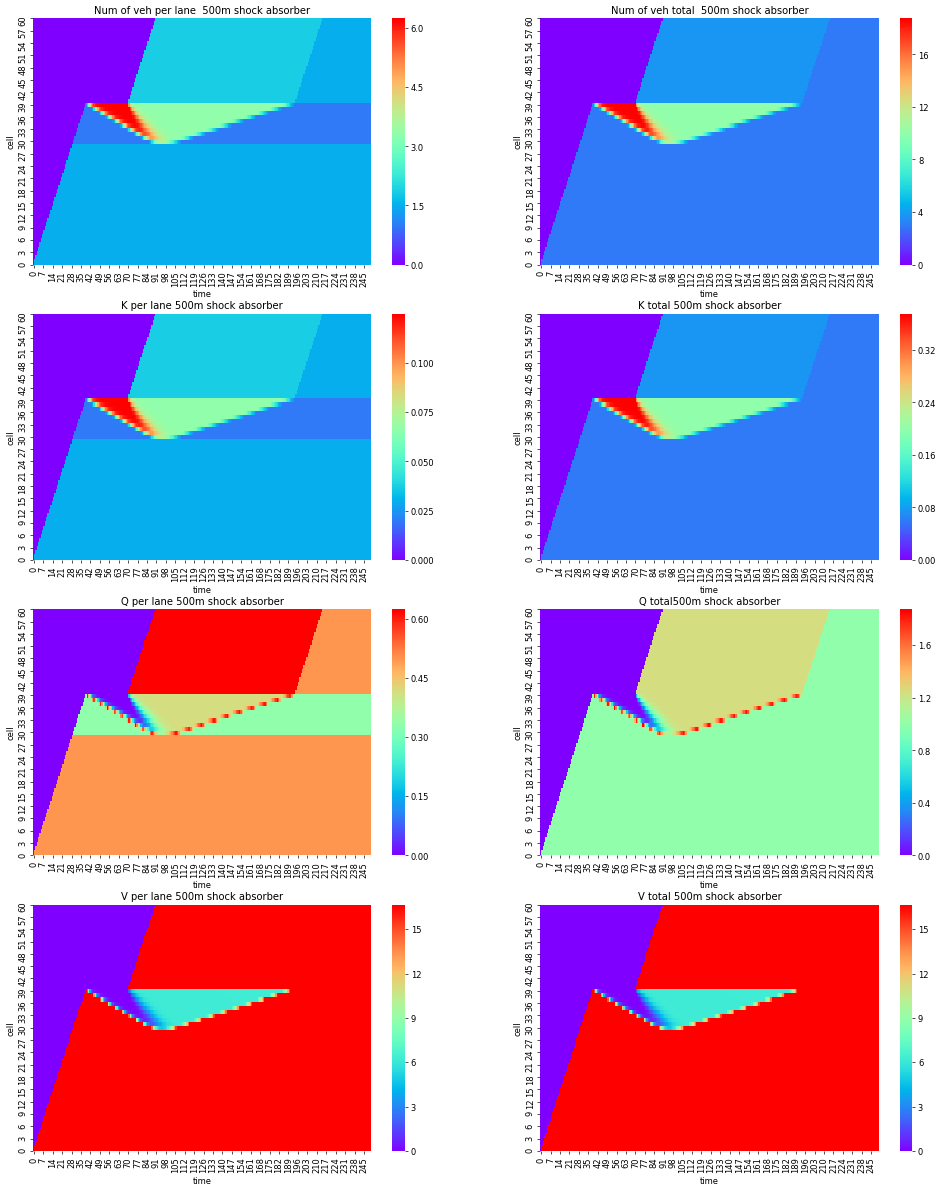

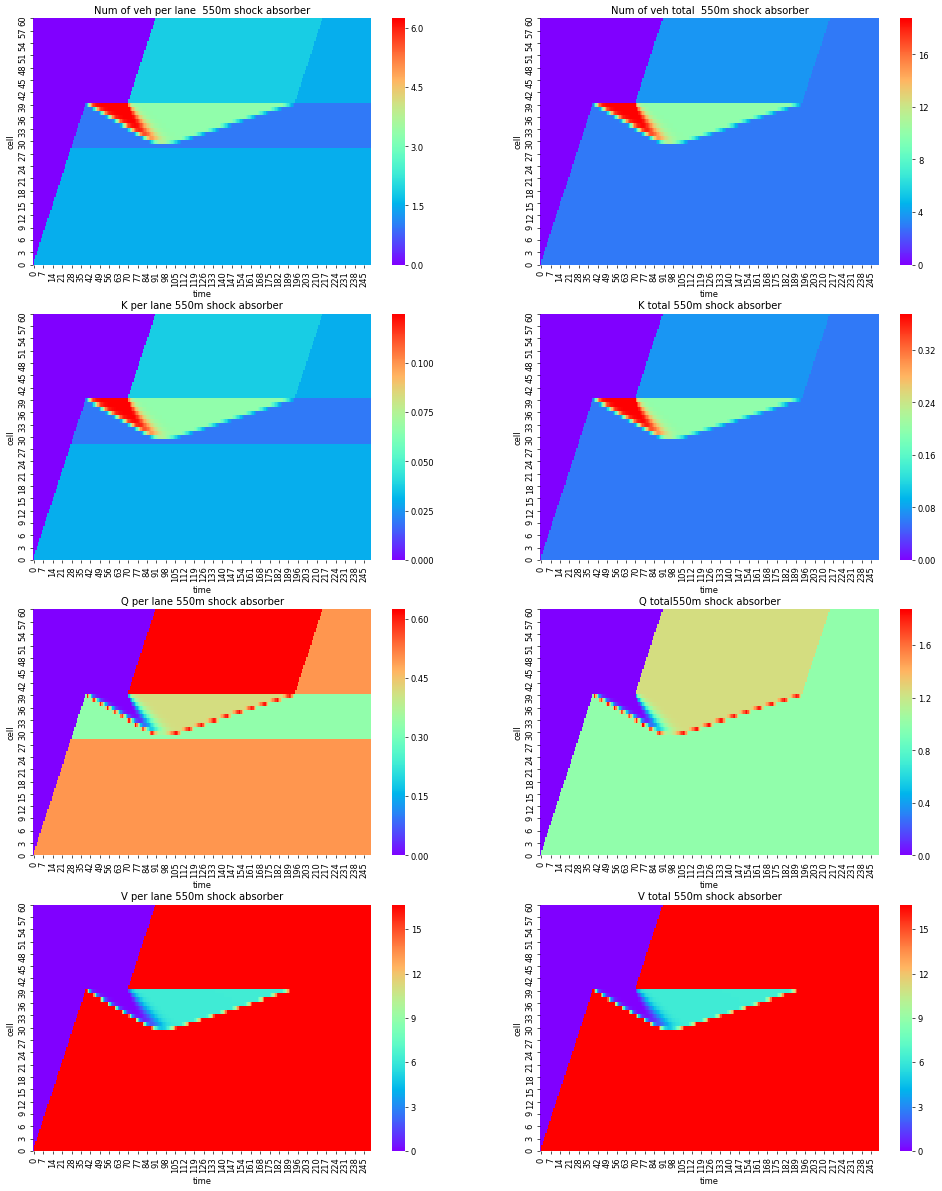

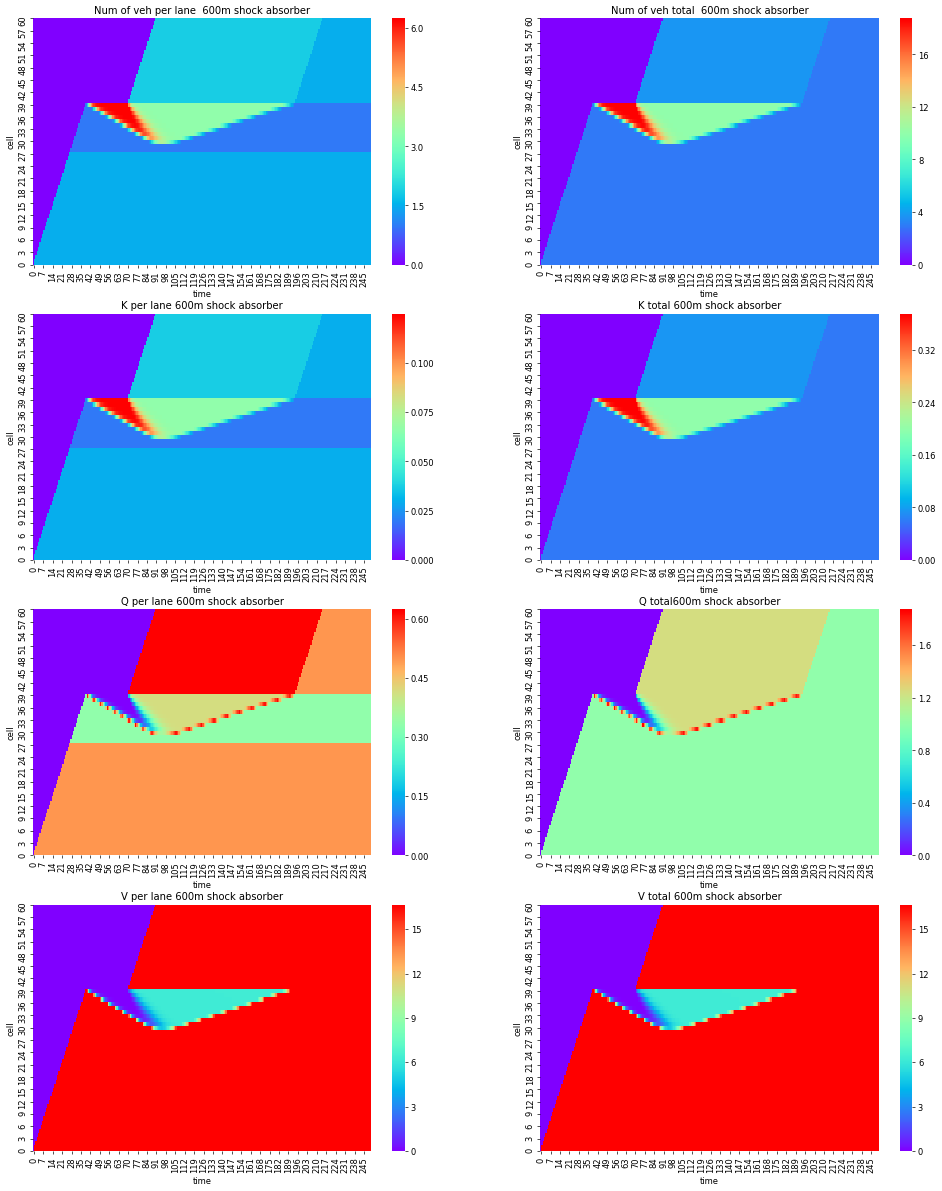

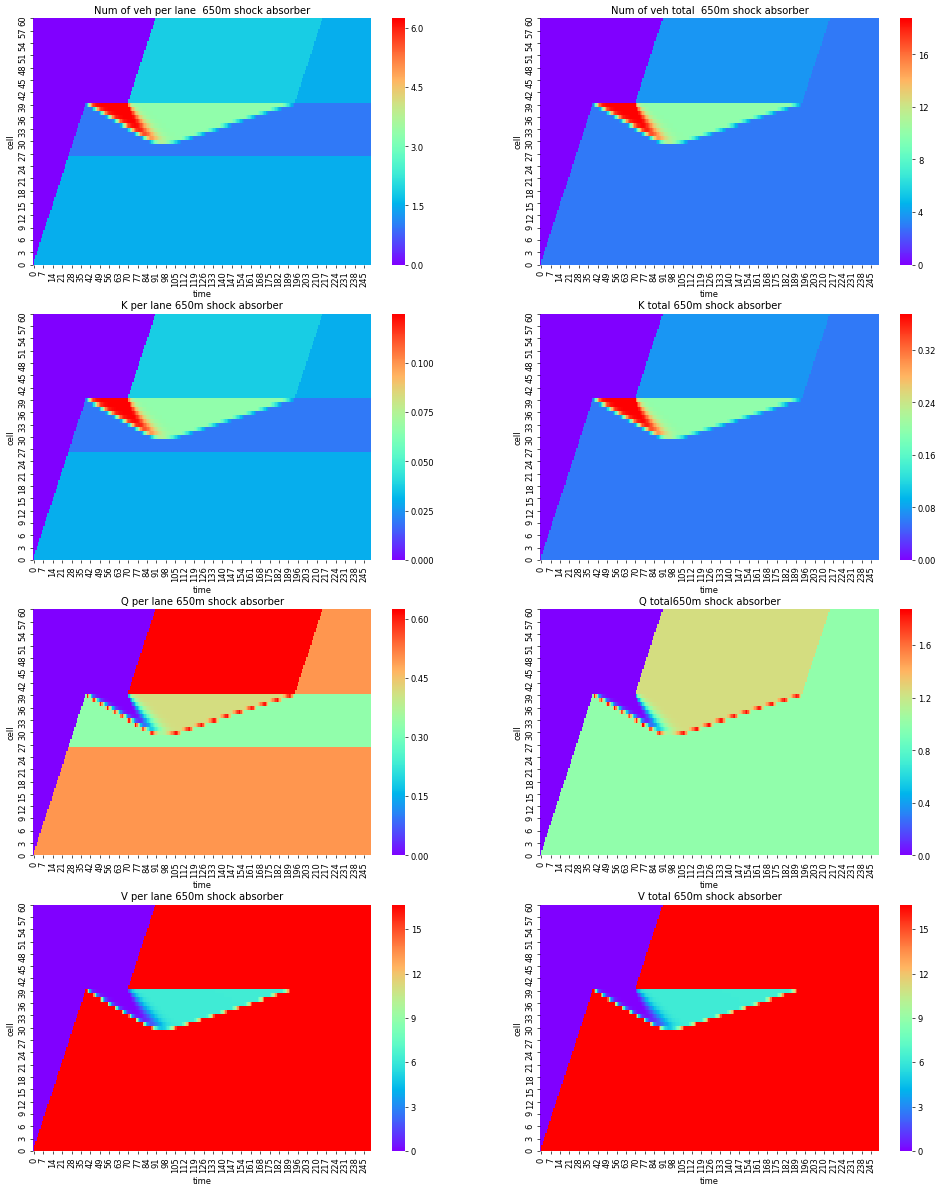

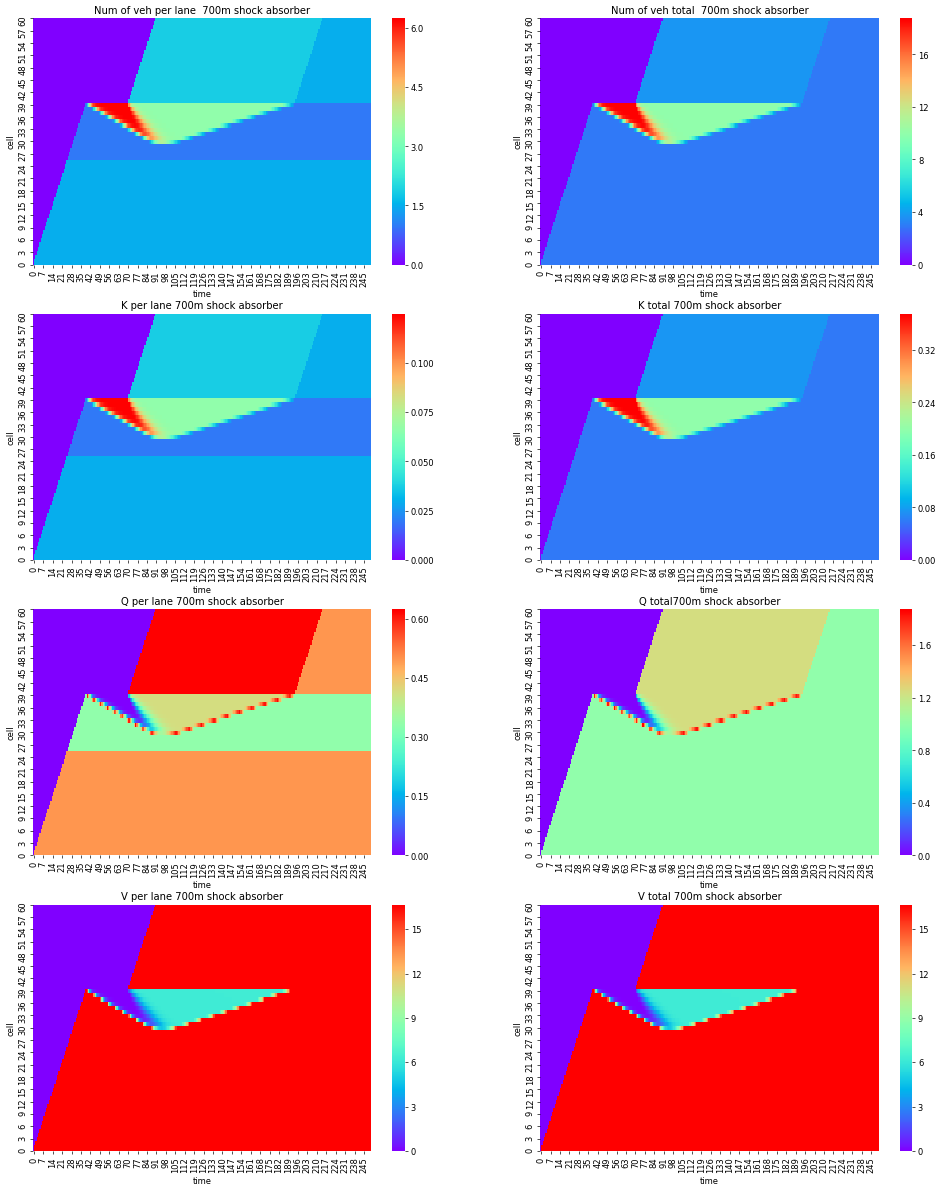

In [4]:
end  = 40
result_total=[]
for i in range(0,15):
    start = end-i
    result = pic(start,end)
    
    result_total.append(result)
    
    fig = plt.figure(num=1, figsize=(20, 25),dpi=60)
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)

    ax1.set_title('Num of veh per lane  '+str(i*50)+'m '+'shock absorber') 
    ax2.set_title('Num of veh total  '+str(i*50)+'m '+'shock absorber')
    ax3.set_title('K per lane '+str(i*50)+'m '+'shock absorber')
    ax4.set_title('K total '+str(i*50)+'m '+'shock absorber')
    ax5.set_title('Q per lane '+str(i*50)+'m '+'shock absorber')
    ax6.set_title('Q total'+str(i*50)+'m '+'shock absorber')
    ax7.set_title('V per lane '+str(i*50)+'m '+'shock absorber')
    ax8.set_title('V total '+str(i*50)+'m '+'shock absorber')

    sns.heatmap(data=np.rot90(result[0][::-1], -1), vmin = 0,ax = ax1, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[1][::-1], -1), vmin = 0,ax = ax2, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[2][::-1], -1), vmin = 0,ax = ax3, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[3][::-1], -1), vmin = 0,ax = ax4, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[4][::-1], -1), vmin = 0,ax = ax5, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[5][::-1], -1), vmin = 0,ax = ax6, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[6][::-1], -1), vmin = 0,ax = ax7, cmap='rainbow') 
    sns.heatmap(data=np.rot90(result[7][::-1], -1), vmin = 0,ax = ax8, cmap='rainbow') 
    
    ax1.set_xlabel("time")
    ax1.set_ylabel("cell")
    ax2.set_xlabel("time")
    ax2.set_ylabel("cell")
    ax3.set_xlabel("time")
    ax3.set_ylabel("cell")
    ax4.set_xlabel("time")
    ax4.set_ylabel("cell")
    ax5.set_xlabel("time")
    ax5.set_ylabel("cell")
    ax6.set_xlabel("time")
    ax6.set_ylabel("cell")
    ax7.set_xlabel("time")
    ax7.set_ylabel("cell")
    ax8.set_xlabel("time")
    ax8.set_ylabel("cell")
      
    ax1.invert_yaxis()
    ax2.invert_yaxis()
    ax3.invert_yaxis()
    ax4.invert_yaxis()
    ax5.invert_yaxis()
    ax6.invert_yaxis()
    ax7.invert_yaxis()
    ax8.invert_yaxis()

    plt.savefig(str(i*50)+'m2 '+'.jpg',dpi=400,bbox_inches='tight')   
    plt.show()    

# Qusetion and Answer

### 1.  How do you program the stop-and-go wave using the CTM? 

When the vehicle arrives at a traffic light junction, if the traffic light is green, the vehicle will continue to move forward, if the traffic light is red, the vehicles will slow down and stop, and queue up in the driving lane. When the red light turns green, the vehicles start and move forward. In this process, a shock wave is emerging at the space – time domain of the road passing through this traffic light junction. Motivated by this case, we make an attempt to set up an obstacle function to implement the Stop and Go Wave in our program. In this function, we set the capacity of a cell to zero, thus, the traffic flow of the previous cell cannot flow into this cell. According to the calculation of equation:   

<center>$cell_{t}^{i}=cell_{t-1}^{i}+cell_{in}^{i}-cell_{out}^{i}$</center> 
<center>$cell_{out}^{i} = min(cell_{occupancy}^{i},min(Q^{i},Q^{i+1}),cell_{capacity}^{i+1}-cell_{occupancy}^{i+1})$ </center>  

The demand and inflow of this cell are always zero. It means that vehicles arriving here must wait in place. Further, in order to realize automatic simulation, a release time is set, that is, the capacity of the selected cell is restored to original value when running to a certain time step. So, the vehicles can pass through other cells and move to the destination continually.

### 2.  Present the speed, density and flow contour before and after using the shock absorber. Comment on the impacts of the length of the shock absorber.


The speed, density and flow contour have already shown in the results page.  
Each page has eight pictures,they are:  

|  |  |
|:  ----  | ----  :|
| Number of vehicles per lane | Total number of vehicles per lane |
| K per lane | K total| 
| Q per lane | Q total| 
| V per lane | V total|   

There are fifteen pages of graphs, each representing a length of shock absorber.

When the shock absorber increases from 0m to 700 in steps of 50m each time, we can see obvious changes in speed and density. When the shock absorber is 0-500m, queue lengths will continue to decrease. However, when the shock absorber is 500-700m, K and V will not change with the increase of shock absorber, the queue lengths is in a stable state, indicating that 500m is a critical value in our model, Represents the best length.

### 3.  What is the length of the shock absorber in your simulation? What is the result when the length is shorter or longer? Can you determine the optimal length of the shock absorber?

In order to test the impact of shock absorber on traffic flow, we tested 15 shock absorbers with different lengths, all of which are extended from 0 to 15 cells upstream from the place where the congestion occurs, taking 0, 50，100，150，200，250，300，350... 700m shock absorber.
Results: As shown in the heat figure，at 0m, there are about 6 cells congested, and at 50m shock absorber, there are about 9 cells congested. With the increase of the length, the number of cells congested becomes larger and larger. When the shock absorber reaches 500m, the congestion disappears. At this time, the length increases and will no longer affect the results.
In our simulation results, the optimal value is 500m. After the length increases, the result is no longer affected by the length.q	


### 4.  Plot time series of arrival rate (outflow of the studied system), cumulative curve of the arrival rate and the slanted cumulative curve of the arrival rate. Comment on the features of the slanted cumulative curve.

We need to calculate the cumulative number of vehicles leaving the whole road. The cumulative arrival rate image is obtained by adding up the number of vehicles arriving at the last cell of each time step in the result page.  
Calculate the cumulative value of vehicles leaving the whole road. The cumulative arrival rate image is obtained by adding up the number of vehicles arriving at the last cell of each time step in the result page.
Considering the slope of the image, it is clear that the slope represents the flow rate leaving the road, and this value is also unchanged between different length of shock absorber.

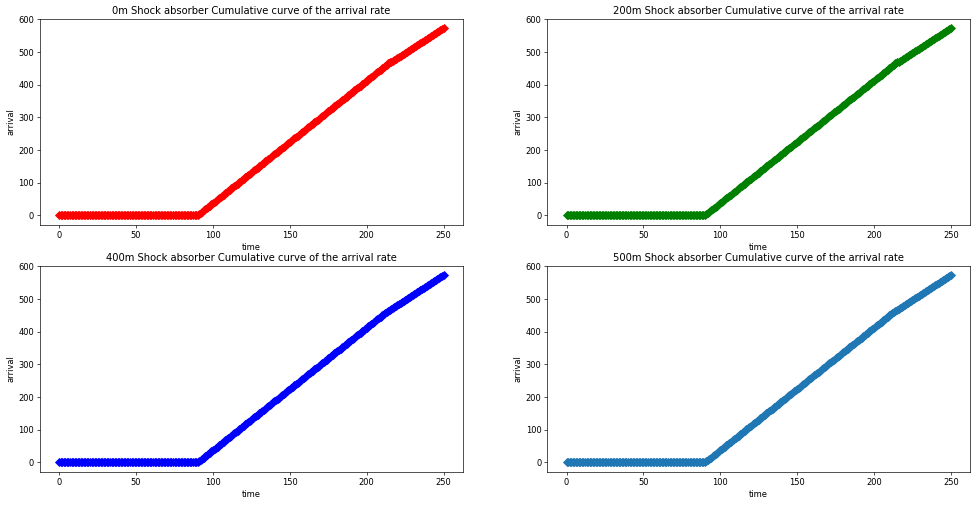

In [5]:
arrivel = []
for j in range (0,15):
    a = result_total[j][1][:,-2]
    for i in range(1,len(a)):
        a[i]=a[i]+a[i-1]
    arrivel.append(a)

fig = plt.figure(num=1, figsize=(20, 10),dpi=60)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

x = range(0,251)



ax1.plot(x, arrivel[0], "r", marker='D')
ax2.plot(x, arrivel[4], "g", marker='D')
ax3.plot(x, arrivel[8], "b", marker='D')
ax4.plot(x, arrivel[10], "s", marker='D')

ax1.set_title('0m Shock absorber Cumulative curve of the arrival rate')
ax1.set_xlabel("time")
ax1.set_ylabel("arrival")
ax2.set_title('200m Shock absorber Cumulative curve of the arrival rate')
ax2.set_xlabel("time")
ax2.set_ylabel("arrival")
ax3.set_title('400m Shock absorber Cumulative curve of the arrival rate')
ax3.set_xlabel("time")
ax3.set_ylabel("arrival")
ax4.set_title('500m Shock absorber Cumulative curve of the arrival rate')
ax4.set_xlabel("time")
ax4.set_ylabel("arrival")

plt.savefig("1.jpg")
plt.show()

### 5.  Will the shock absorber reduce travel time? Will the shock absorber reduce Total Time Spent? Why?

- The graphs show that the arrival rate does not change no matter how we adjust the length and position of the shock absorber. Although our maximum queue length varies with the shock absorber, both the queue time and queue dissipation time (i.e., total congestion time $t_{jam}$) are unchanged.  
- The travel time of each vehicle is constant in terms of the whole process.  
- We try to analyze the reason for this. The queue eventually dissipates regardless of whether a shock absorber is added, so the shock wave does not affect locations further upstream on the road. On the other hand, the capacity bottleneck is at the location where the lanes are reduced after congestion, and the capacity at this location determines the final vehicle arrival rate, which also determines that travel time and total time do not change.

<img src="pic/t.png" width = "600" height = "600" alt="pic" align=center />